# Preprocessing of EEG data
In this notebook, we will go through the basics of preprocessing EEG data using MNE. We will be using the MNE sample data from an experiment. 

## Using this notebook
The code in this notebook is divided into cells. You can execute the code in each cell by pressing the play button (▶) in the top left, or using the shortcut Ctrl+Enter. The output of the code is shown beneath the cell.

The workflow of preprocessing is as follows:
1. Load the data
2. Exclude bad channels
3. Common average reference
4. Filtering
5. Artefact rejection
6. Epoching
7. Downsampling

After preprocessing, we average over trials to get the evoked response and plot the result.

## Setting up Python
But before we can get to all the fun coding, we need to make sure we have the python packages we need to run the analysis!

#### Creating virtual environment with packages
The following code chunk creates a virtual environment by running a bash script and installs the requirements specified in `requirements.txt`. In theory you only need to run this code once - as it saves all the packages in a folder called `env`. However, if you update your requirements file you need to run the code again to include new packages. 

<div class="alert alert-block alert-info"><b>Note:</b>
To be able to run the following code you need to press "Select Kernel" in the top right corner and then press Python Environments. Choose the available python kernel! If no python kernel is available, make sure you are using Coder Python version 1.93.1 on uCloud. 

In [59]:
!bash ../setup_env.sh

Done!


#### Install IPython kernel within the virtual environment
The following code executes a Bash script, which informs the Jupyter kernel that a new virtual environment has been created and should be available for use. By adding this code to other notebooks, you won't have to install packages every time you start a new uCloud run.

In [60]:
!bash ../env_to_ipynb_kernel.sh

Installed kernelspec env in /home/ucloud/.local/share/jupyter/kernels/env


#### Select the correct kernel
Before you can use the packages installed, you need to change the kernel used to run the code in this notebook. Now lets change the kernel to the one including all our installations. Press where it says `Python X.XX.XX` in the top right corner, then `Select Another Kernel`, then `Jupyter kernel...` and then select `env`. If `env` does not show up, press the little refresh symbol! 

#### Importing the packages
Now we are ready to start playing around with EEG data!

In [61]:
import mne
from mne.datasets import sample
from pathlib import Path
import matplotlib

%matplotlib inline

## 1. Load the sample data
To begin with we load the MNE sample data. It contains data from an experiment where checkerboard patterns were presented to the subject into the left and right visual (hemi)field, interspersed by tones to the left or right ear. The interval between the stimuli was 750 ms. Occasionally a smiley face was presented at the center of the visual field. The subject was asked to press a key with the right index finger as soon as possible after the appearance of the smiley.

Looking at trials across modalities (auditory/visual) we can see the contrast between auditory and visual processing, while inspecting the left/right trials allows us to observe the contralateral visual processing of the brain (i.e. what is presented to the right visual hemifield is processed in the left visual cortex and vice versa).



In [62]:
data_path = Path("/work/EEG_lab")


# this line of code was run to download the sample data to the EEG_lab folder (you do not have to run it, which is why it is commented out!)
# sample.data_path(path=data_path, update_path=True, download=True, verbose=None) 

raw_fname = data_path / "MNE-sample-data" / 'MEG/sample/sample_audvis_filt-0-40_raw.fif'
raw = mne.io.read_raw_fif(raw_fname)
raw.load_data()

Opening raw data file /work/EEG_lab/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Reading 0 ... 41699  =      0.000 ...   277.709 secs...


<Raw | sample_audvis_filt-0-40_raw.fif, 376 x 41700 (277.7 s), ~122.8 MB, data loaded>

### Questions
Looking at the ouput from the load_data() function, answer the following questions:

**Q1:** How many EEG channels are there?
**A:** 

**Q2:** Were any EEG channels marked as bad during recording?
**A:**

**Q3:** What is the sampling frequency (i.e., how many data points are collected for each channel each second)?
**A:**

**Q4:** How many minutes of data were recorded?
**A:**

**Now lets try and plot the raw data!**

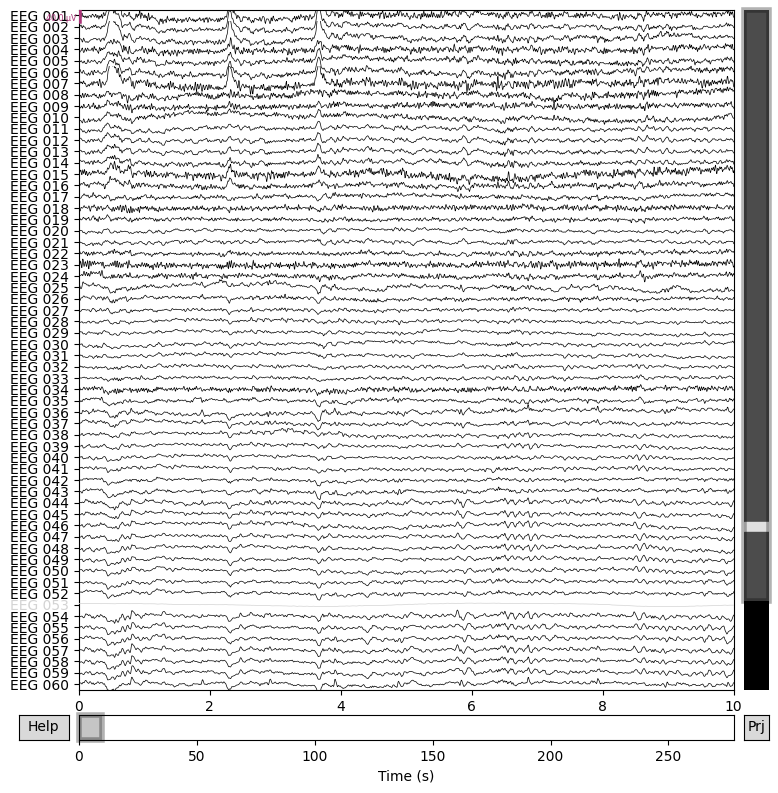

In [63]:
# Both EEG and MEG (grad and mag) were recorded, but we are only interested in working with the EEG data
# selecting only EEG and stimulus data & plotting raw data
raw.pick(['eeg', 'stim'])
raw.plot(n_channels=60);

**Plot the first 20 channels instead of 60**

In [64]:
# insert your code here

## 2. Exclude bad channels
When plotting all channels simultaneously, it is evident that one of the channels is not really picking up any signal (that is, it is flat). This is a bad channel and should be excluded from further analysis. There are other ways that channels might be bad, such as being too noisy. In this case, we will just exclude the channel that is flat.

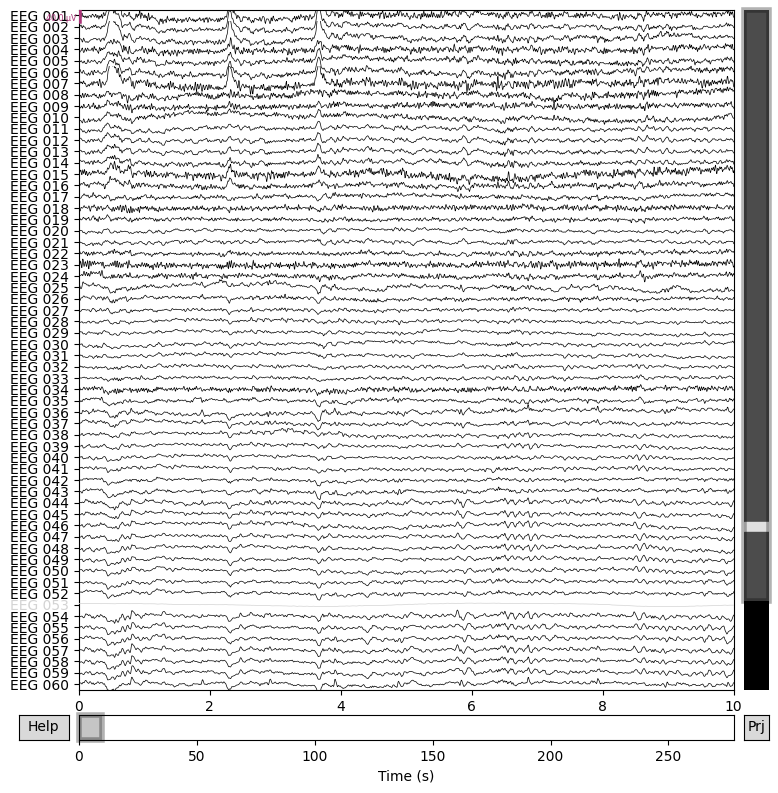

In [65]:
# Marking the channel as bad
raw.info['bads'] = ['EEG 053']

# Checking that we have marked the correct channel as bad
raw.plot(n_channels=60);

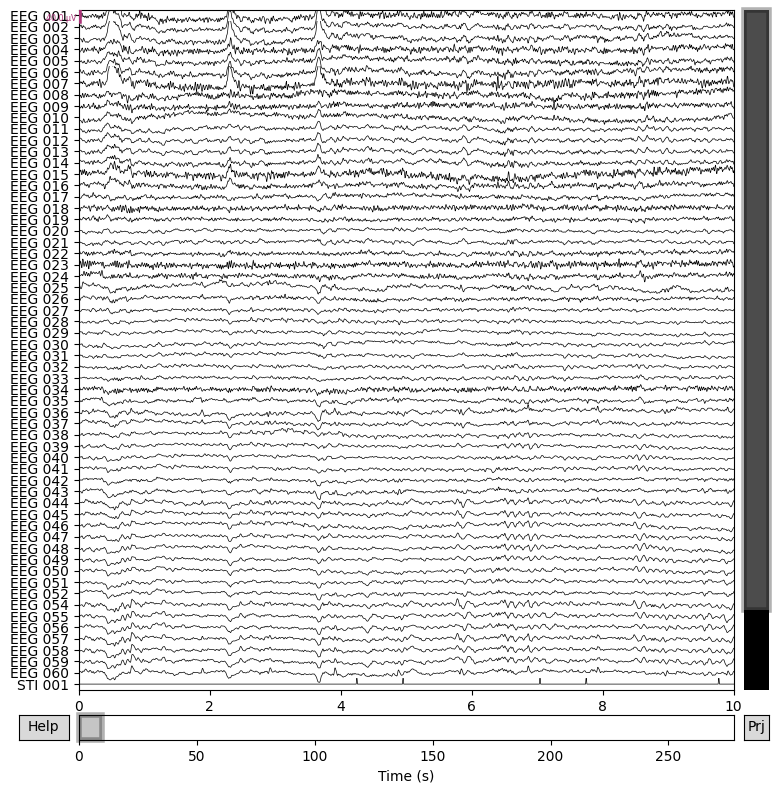

In [66]:
# removing the bad channel
raw.pick(['eeg', 'stim'], exclude='bads')

# Plotting the data again to see that the bad channel has been removed
raw.plot(n_channels=60);

## 3. Common average reference
The idea behind common average reference is to compute the average of the signal at all EEG electrodes and subtract it from the EEG signal at every electrode for every time point. To set this “virtual reference” that is the average of all channels, you can use set_eeg_reference() with ref_channels='average'. This is done after excluding bad channels, so the average is computed only over the good channels.

The rationale behind this is that the average of all the potentials recorded on the whole head due to current sources inside it is zero, this would make for a quiet or electrically neutral reference. However, in practice, to achieve such an ideal reference one would require large number of electrodes that cover the whole head uniformly, which is not the case in EEG recordings where limited number of electrodes cover mostly the upper part of the head.

<div class="alert alert-block alert-info"><b>Note:</b>
The data used here has already been referenced to the average of all channels, but this code will be needed when you analyse your own data!

In [67]:
# common average reference
# raw.set_eeg_reference('average', projection=True)

# applying the reference
# raw.apply_proj()

## 4. Filtering
Now let's filter the data. We apply a high-pass filter at 0.1 Hz and a low-pass filter at 40 Hz, following the typical practises of EEG preprocessing. The high-pass filter minimises slow drifts in the data (e.g. scalp potentials), while the low-pass filter excludes high-frequency noise, e.g. line noise (50 Hz or 60 Hz) or EMG (muscle-related artefacts), with frequencies higher than the frequencies of the signal we are interested in.

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 4957 samples (33.013 s)



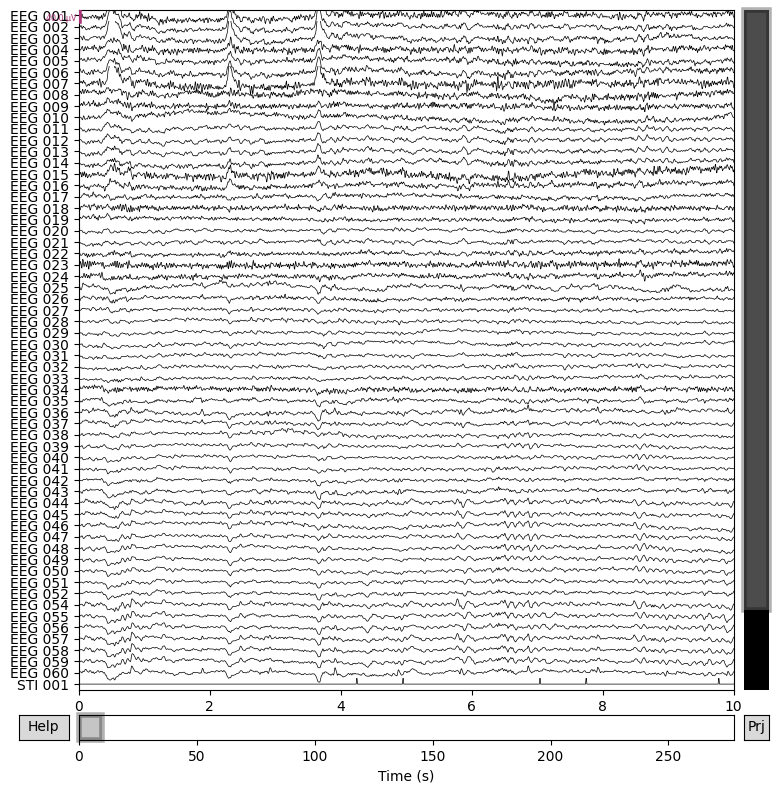

In [68]:
raw_filtered = raw.copy()

# high-pass filtering the data at 0.1 Hz and low-pass filtering at 40 Hz
raw_filtered = raw_filtered.filter(0.1, 40)

# plotting the filtered data for inspection
raw_filtered.plot(n_channels=60);

### Questions
**Q5:** If you compare the raw data with the filtered data, what differences do you see?
**A:**

## 5. Artefact rejection
Not all noise is outside the frequency range of brain activity and can therefore not just be suppressed by filtering. Some artefacts, like eye blinks, comprise large jumps in activity. Since such large shifts are unlikely to be related to brain activity, we can exclude parts of the recording where this happens. We do this by selecting a threshold value for the peak-to-peak amplitude. When we epoch our data, we exclude epochs that contain "jumps" of more than ±150 microvolts in the signal, i.e. epochs where the subject likely blinked.

In [69]:
# rejecting everything over or under a threshold of 150 microvolts
# anything above or belove this threshold is likely not brain activity but artefacts

# for now we are just defining the threshold, we will apply it later when we are creating epochs
reject = dict(eeg=150e-6)# 150 µV

## 6. Epoching
Now that the data has been preprocessed, we can epoch the data. Epoching is the process of cutting the continuous data into smaller segments, called epochs. Each epoch is a time window of the data, centered around an event of interest.

To begin with we find the events that were recorded during the experiment. 

In [70]:
# this function locates any stimulus events in the recording (e.g. presentation of stimuli or button presses)
events = mne.find_events(raw_filtered)

319 events found on stim channel STI 014
Event IDs: [ 1  2  3  4  5 32]


In [71]:
# we can make a dictionary of what the event IDs represent
# by using '/' we can actually later index one dimension *across* the other, i.e. if we just write 'left' we get all events presented to the left side, both auditory and visual
event_id = {'auditory/left': 1,
              'auditory/right': 2,
              'visual/left': 3,
              'visual/right': 4,
              'smiley': 5,
              'button': 32
              }

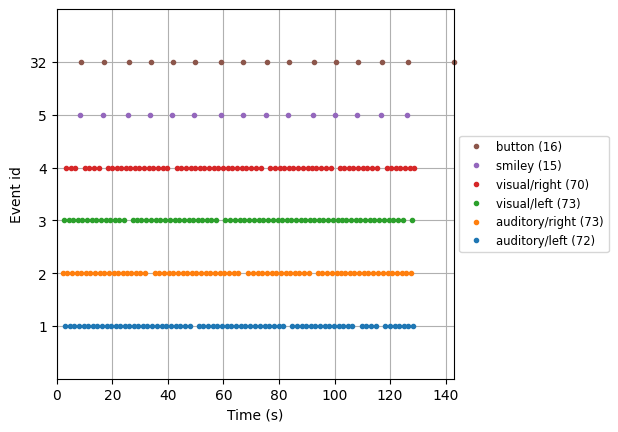

In [72]:
# plotting the events
mne.viz.plot_events(events, sfreq=250, first_samp=raw.first_samp, event_id=event_id);

We can identify the timepoints during the recording where both visual and auditory stimuli were presented, as well as when the subject was presented with a smiley and responded with a button press. Since we are interested in the presentation of stimuli, we create our epochs around these events. The time window we establish span from 0.2 seconds before stimulus onset to 0.5 seconds after stimulus onset. The 200 milliseconds before the onset of the stimulus enables us to establish a baseline of "no activity", i.e. without stimulus presentation, which we can subtract from our time window with activity in order subtract away the background activity. The 500 milliseconds after the stimulus onset denote the time in which we expect the effect to occur, since the relevant EEG components for this kind of task arise within 500 milliseconds of stimulus onset. 

In [73]:
# establishing time window
tmin, tmax = -0.2, 0.5

In [74]:
# creating the epochs using the variables created in the cell above, and timelocking to the events
# baseline time interval spans from beginning of the data (-0.2 s) to 0 s (stimulus onset)
# we use the reject variable we created earlier in order to remove artefacts
epochs = mne.Epochs(raw_filtered, events, event_id, tmin, tmax, picks=["eeg"],
                    baseline=(None, 0), reject=reject, preload=True)

Not setting metadata
319 matching events found
Setting baseline interval to [-0.19979521315838786, 0.0] s
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 1)
1 projection items activated
Using data from preloaded Raw for 319 events and 106 original time points ...
    Rejecting  epoch based on EEG : ['EEG 001', 'EEG 002', 'EEG 003', 'EEG 007']
    Rejecting  epoch based on EEG : ['EEG 008']
2 bad epochs dropped


As you can see, we are dropping some epochs that were deeemed 'bad' because they contain peak-to-peak values over the threshold we defined, allowing us to exclude epochs with artefacts in order to try to keep as much noise out of our data as possible.

## 7. Down sampling
To reduce the amount of data we have to work with as well as the amount of time it takes to run the analysis the data is downsampled. This is done after creating the epochs, as doing so before can potentially mess with the precision of the extraction of epochs.

In [75]:
# downsampling to 250 Hz
epochs_resampled = epochs.resample(250)

## 8. Analysis (Event related potentials)
We can now average over epochs across our modalities (auditory/visual) and take a look at whether there seems to be a difference between our conditions when we average out the noise from individual trials.

In [76]:
# now the '/' used in the event IDs comes in handy! To get all epochs with auditory stimuli, we can index 'auditory' across the left/right dimension (and 'visual', of course)
# that way we don't have to specify 'auditory_left' and 'auditory_right' etc.
aud_epochs = epochs_resampled['auditory']
vis_epochs = epochs_resampled['visual']

# creating evokeds for auditory condition by averaging over epochs
aud_evoked = aud_epochs.average()

# creating evokeds for visual condition
vis_evoked = vis_epochs.average()

combining channels using GFP (eeg channels)
combining channels using GFP (eeg channels)


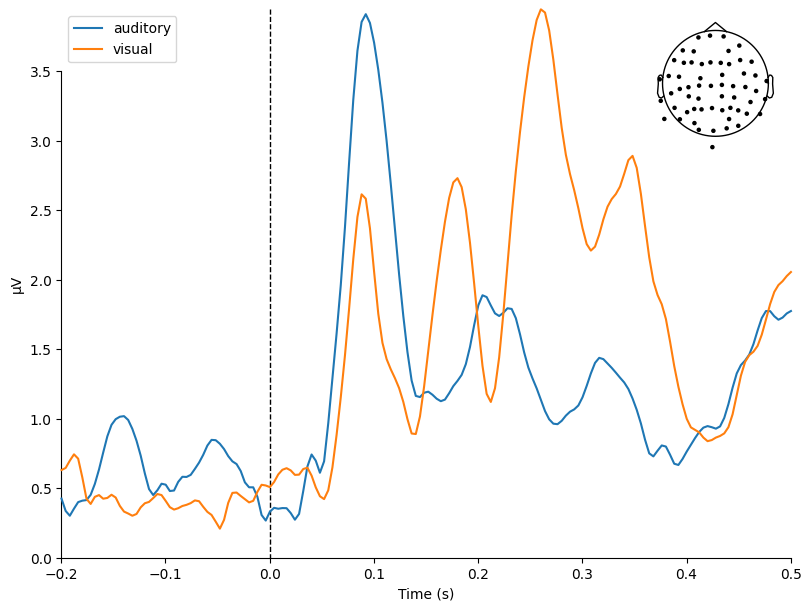

In [77]:
# comparing the two conditions
mne.viz.plot_compare_evokeds(dict(auditory=aud_evoked, visual=vis_evoked),
                             legend='upper left', show_sensors='upper right');

We can also plot the signal from one channel at a time!

Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated


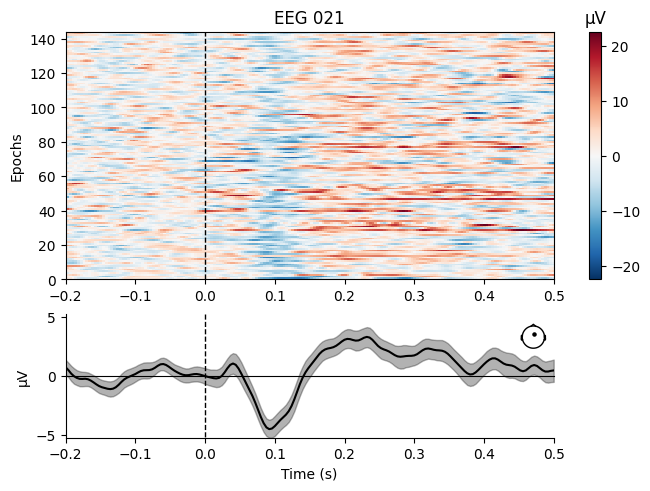

Not setting metadata
143 matching events found
No baseline correction applied
0 projection items activated


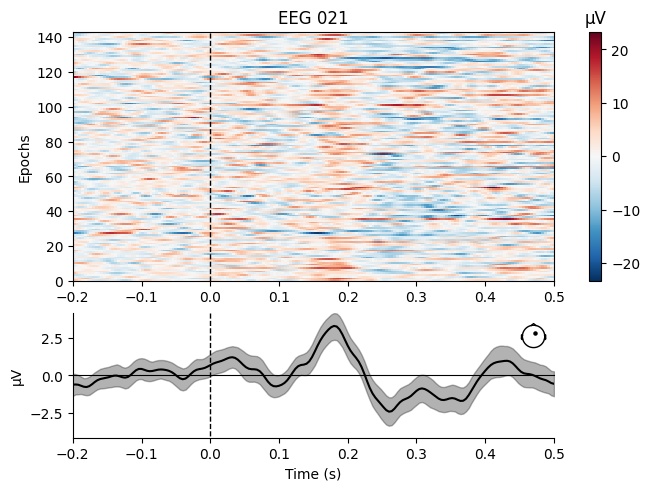

[<Figure size 640x480 with 4 Axes>]

In [78]:
# Plotting the signal from one channel for all epochs!
aud_epochs.plot_image(picks=["EEG 021"])
vis_epochs.plot_image(picks=["EEG 021"])

# Extra exercises

### 1. Can you find a channel that might show a more clear signal for visual epochs rather than auditory epochs as in the example above?

In [79]:
# insert your code here

**Hint:** Use the code chunk below to get the names and location of the channels

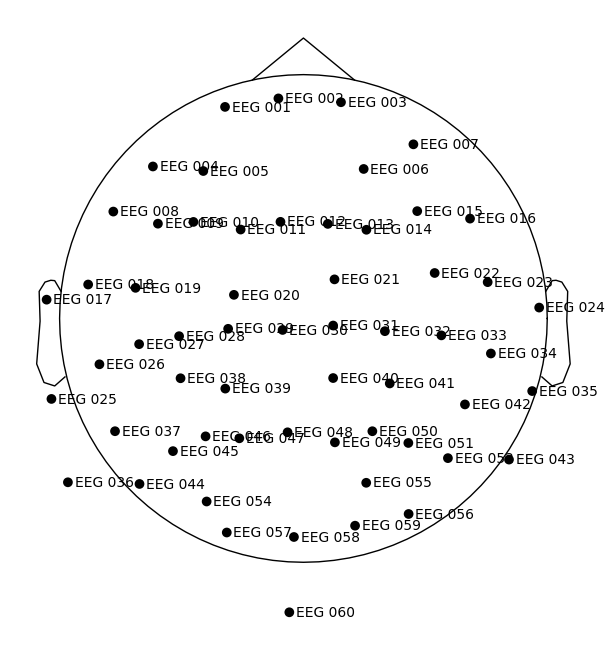

In [80]:
epochs.plot_sensors(show_names=True);

### 2. Contrast visual stimuli presented to the left and right hemisfield!

In [81]:
# STEP 1: create two variables - vis_left_epochs and vis_right_epochs
vis_left_epochs = epochs["visual/left"]
# .... INSERT CODE HERE

In [82]:
# STEP 2: Compute the evoked responses vis_left_evoked and vis_right evoked
vis_left_evoked = vis_left_epochs.average()
# INSERT YOUR CODE HERE

In [83]:
# STEP 3: compare the evoked responses of the two conditions using the mne.viz.plot_compare_evokeds function

**Describe with a few sentences what the plot shows!**